In [1]:
# =============================================================================
# Github code for Enrichment Analysis using Enrichr
# =============================================================================

import json
import requests
import numpy as np
import altair as alt
import pandas as pd
import mygene

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


class EnrichR(object):
    def __init__(self, list_genes):
        self.list_genes = list_genes
        self.len_list = len(list_genes)

    @classmethod
    def get_libraries(cls):
        """Return active Enrichr library names. Official API."""
        lib_url = 'https://maayanlab.cloud/Enrichr/datasetStatistics'
        response = requests.get(lib_url, verify=True)
        if not response.ok:
            raise Exception("Error getting the Enrichr libraries")
        libs_json = json.loads(response.text)
        libs = [lib['libraryName'] for lib in libs_json['statistics']]
        return sorted(libs)

    @classmethod
    def get_id(cls, list_genes):
        ENRICHR_URL = 'https://maayanlab.cloud/Enrichr/addList'
        genes_str = '\n'.join(list_genes)
        description = 'Example gene list'
        payload = {
            'list': (None, genes_str),
            'description': (None, description)
        }
        response = requests.post(ENRICHR_URL, files=payload)
        if not response.ok:
            raise Exception('Error analyzing gene list')
        data = json.loads(response.text)
        user_id = data['userListId']
        return user_id

    @classmethod
    def get_enrichment(cls, list_genes, library_name='KEGG_2021_Human'):
        """
        Retrieve enrichment results.
        Default library is KEGG_2021_Human.
        """
        user_id = cls.get_id(list_genes)
        ENRICHR_URL = 'https://maayanlab.cloud/Enrichr/enrich'
        query_string = '?userListId=%s&backgroundType=%s'
        response = requests.get(
            ENRICHR_URL + query_string % (user_id, library_name)
        )
        if not response.ok:
            raise Exception('Error fetching enrichment results')
        res = json.loads(response.text)
        return res, library_name

    @classmethod
    def get_table_enrichment(cls, list_genes, library_name='KEGG_2021_Human'):
        dct = cls.get_enrichment(list_genes, library_name)
        df = pd.DataFrame(dct[0][library_name])
        df.columns = [
            'Rank', 'Term name', 'P-value', 'Z-score', 'Combined score',
            'Overlapping genes', 'Adjusted p-value', 'Old p-value',
            'Old adjusted p-value'
        ]
        return df

    @classmethod
    def plot_enrichment(cls, list_genes, library_name='KEGG_2021_Human', height=200, width=300, max_hits=None):
        """
        Plot ordered enrichment scores as -log10(pval).
        """
        res, library_name = cls.get_enrichment(list_genes, library_name)
        labels, p_val = [], []
        for entry in res[library_name]:
            labels.append(entry[1])
            p_val.append(entry[2])
        df_plot = pd.DataFrame({'labels': labels, 'pval': p_val})
        df_plot['-log(pval)'] = np.round(-np.log(df_plot['pval']), 2)

        if max_hits is None:
            max_hits = len(df_plot)
        df_plot = df_plot.iloc[:max_hits]

        bars = alt.Chart(df_plot).mark_bar(color='indianred').encode(
            x='-log(pval)', 
            y=alt.Y('labels', sort='-x')
        )
        text = bars.mark_text(
            align='left', baseline='middle', dx=4
        ).encode(text='-log(pval):Q')

        return (bars + text).properties(
            height=height, width=width, title='Enrichment results - ' + library_name
        )

    @classmethod
    def plot_enrichment2(cls, list_of_gene_lists, library_name='KEGG_2021_Human', height=100, width=200, max_hits=None):
        """
        Plot ordered enrichment scores as -log10(pval) for multiple gene lists in a loop.
        """
        for gene_data in list_of_gene_lists:
            gene_list = gene_data["gene_list"]
            plot_title = gene_data.get("title", "Enrichment Results")
            res, library_name = cls.get_enrichment(gene_list, library_name)

            labels, p_val = [], []
            for entry in res[library_name]:
                labels.append(entry[1])
                p_val.append(entry[2])
            df_plot = pd.DataFrame({'labels': labels, 'pval': p_val})
            df_plot['-log(pval)'] = np.round(-np.log(df_plot['pval']), 2)

            if max_hits is None:
                max_hits = len(df_plot)
            df_plot = df_plot.iloc[:max_hits]

            bars = alt.Chart(df_plot).mark_bar(color='indianred').encode(
                x='-log(pval)', 
                y=alt.Y('labels', sort='-x', title="GO Terms ", axis=alt.Axis(labelLimit=200))
            )
            text = bars.mark_text(
                align='left', baseline='middle', dx=4
            ).encode(text='-log(pval):Q')

            chart = (bars + text).properties(
                height=height, width=width, title=plot_title
            )
            # Save to PNG with a high DPI (e.g., 300 DPI)
            chart.save(f"{plot_title}.png", dpi = 300)  # Adjust the scale value for better resolution

    @classmethod
    def plot_enrichment_jpeg(cls, list_of_gene_lists, library_name='KEGG_2021_Human', height=6, width=10, max_hits=None):
        """
        Plot ordered enrichment scores as -log10(pval) for multiple gene lists using Matplotlib.
        """
        for gene_data in list_of_gene_lists:
            gene_list = gene_data["gene_list"]
            plot_title = gene_data.get("title", "Enrichment Results")
            res, library_name = cls.get_enrichment(gene_list, library_name)

            labels, p_vals = [], []
            for entry in res[library_name]:
                labels.append(entry[1])
                p_vals.append(entry[2])

            df_plot = pd.DataFrame({'labels': labels, 'pval': p_vals})
            df_plot['-log(pval)'] = np.round(-np.log(df_plot['pval']), 2)

            if max_hits is None:
                max_hits = len(df_plot)
            df_plot = df_plot.iloc[:max_hits]

            # Plot using Matplotlib
            fig, ax = plt.subplots(figsize=(width, height))
            ax.barh(df_plot["labels"], df_plot["-log(pval)"], color='indianred')
            ax.set_xlabel("-log10(p-value)")
            ax.set_title(plot_title)
            ax.invert_yaxis()  # Highest value at top

            # Save as JPEG
            jpeg_filename = f"{plot_title}.jpg"
            plt.savefig(jpeg_filename, format="jpeg", dpi=300, bbox_inches='tight')
            # plt.show()

            print(f"Saved plot as {jpeg_filename}")


In [3]:
# =============================================================================
# Enrichment Analysis using Enrichr for each gene clusters 
# (considered all genes in the cluster)
# =============================================================================

import pandas as pd

# Load the Excel file
file_path = "cluster_gene_tarining_patients.xlsx"
excel_data = pd.ExcelFile(file_path)

# Initialize an empty list to hold gene lists and their titles
gene_lists = []

# Loop through each sheet in the Excel file
for idx, sheet_name in enumerate(excel_data.sheet_names, start=1):
    # Read the genes from the sheet
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    
    # The gene names are in the first column
    gene_list = df.iloc[:, 0].dropna().tolist()
    
    # Create a dictionary for the current cluster's gene list
    cluster_dict = {"gene_list": gene_list, "title": f"Cluster {idx} Enrichment"}
    
    # Append the dictionary to the gene_lists
    gene_lists.append(cluster_dict)

# # Print the gene_lists to verify
# for cluster in gene_lists:
#     print(f"{cluster['title']}: {cluster['gene_list']}")


Saved plot as Cluster 1 Enrichment.jpg
Saved plot as Cluster 2 Enrichment.jpg
Saved plot as Cluster 3 Enrichment.jpg
Saved plot as Cluster 4 Enrichment.jpg
Saved plot as Cluster 5 Enrichment.jpg
Saved plot as Cluster 6 Enrichment.jpg
Saved plot as Cluster 7 Enrichment.jpg
Saved plot as Cluster 8 Enrichment.jpg
Saved plot as Cluster 9 Enrichment.jpg
Saved plot as Cluster 10 Enrichment.jpg
Saved plot as Cluster 11 Enrichment.jpg
Saved plot as Cluster 12 Enrichment.jpg
Saved plot as Cluster 13 Enrichment.jpg
Saved plot as Cluster 14 Enrichment.jpg
Saved plot as Cluster 15 Enrichment.jpg
Saved plot as Cluster 16 Enrichment.jpg


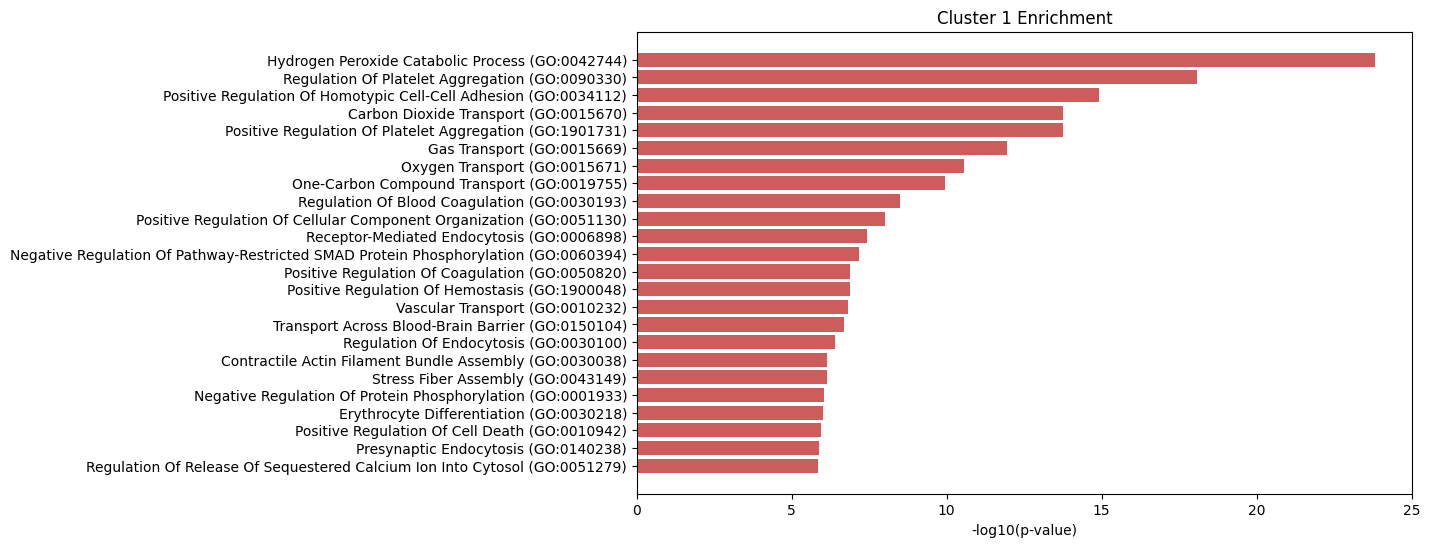

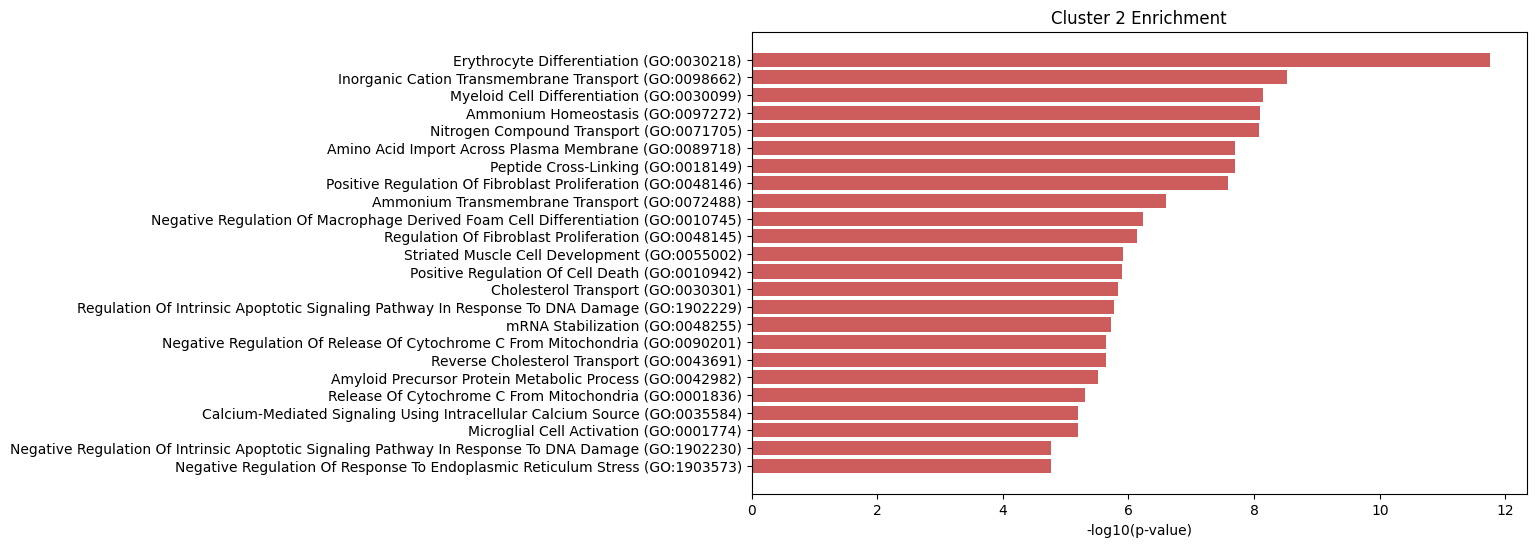

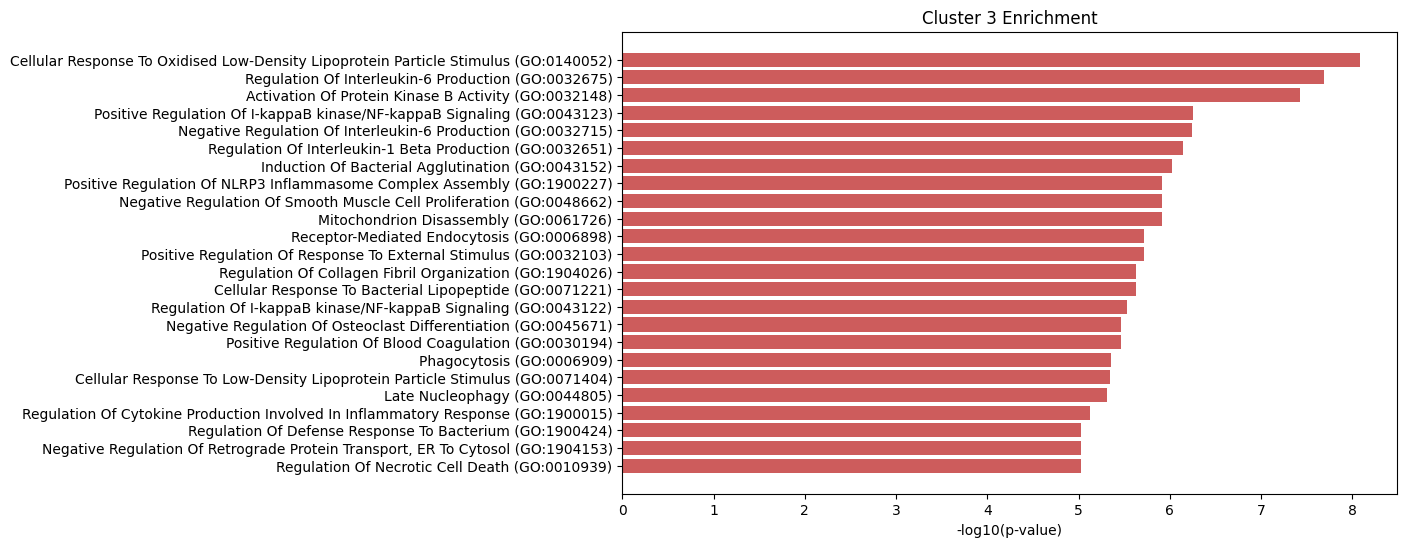

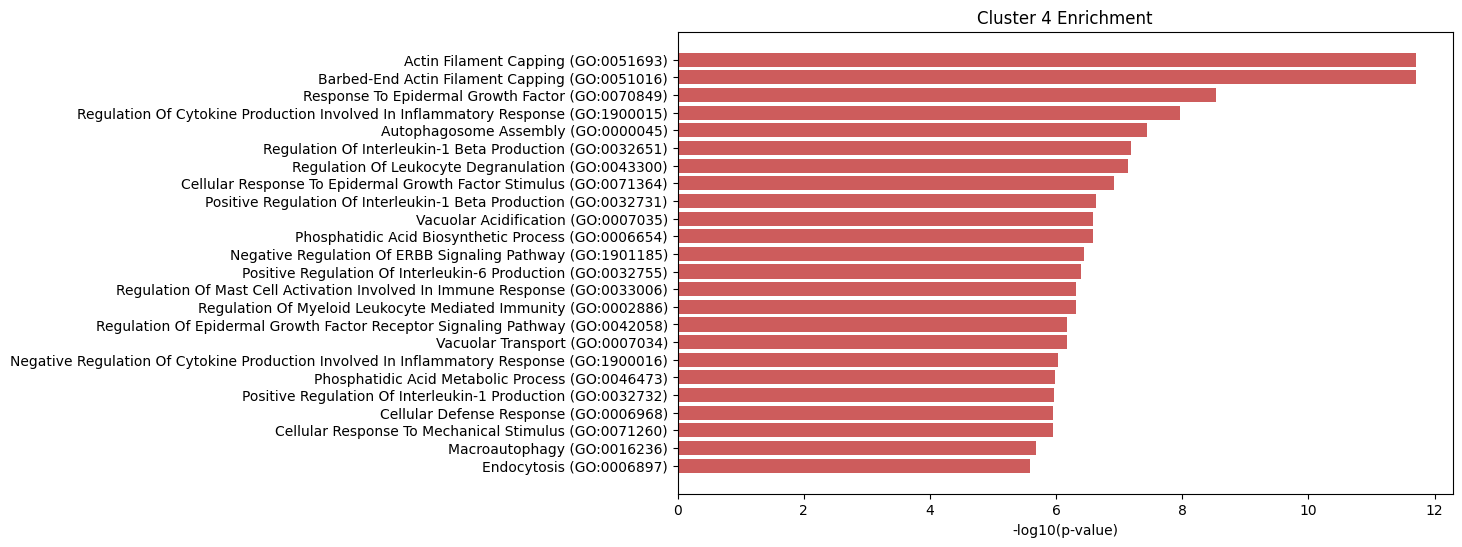

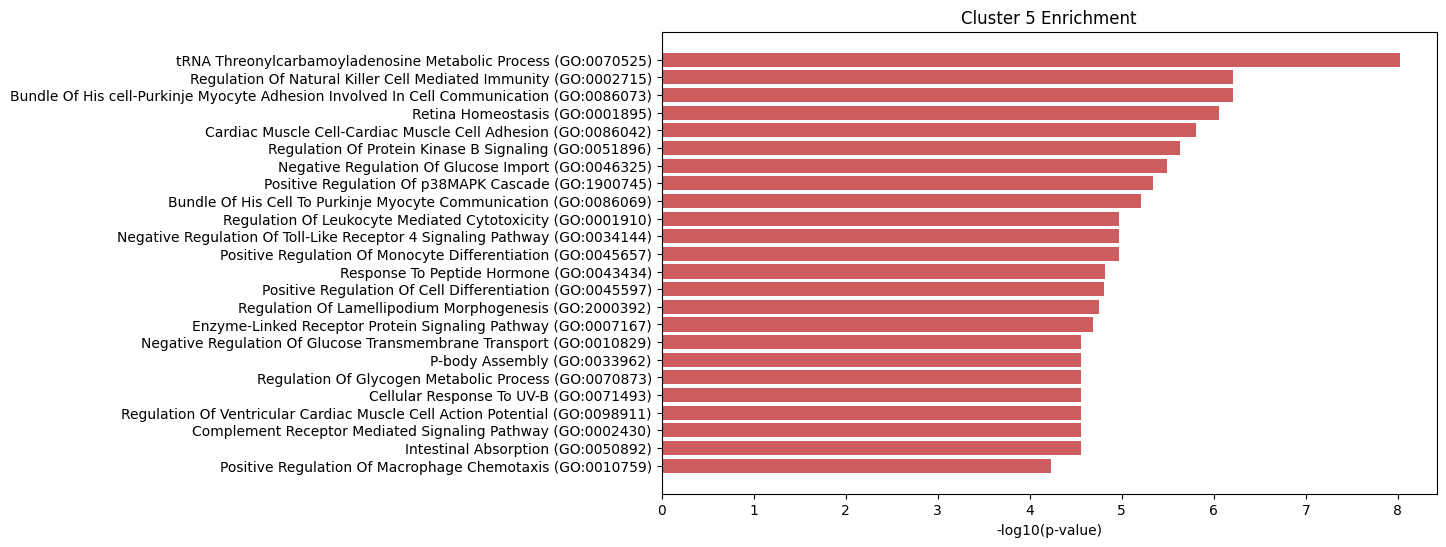

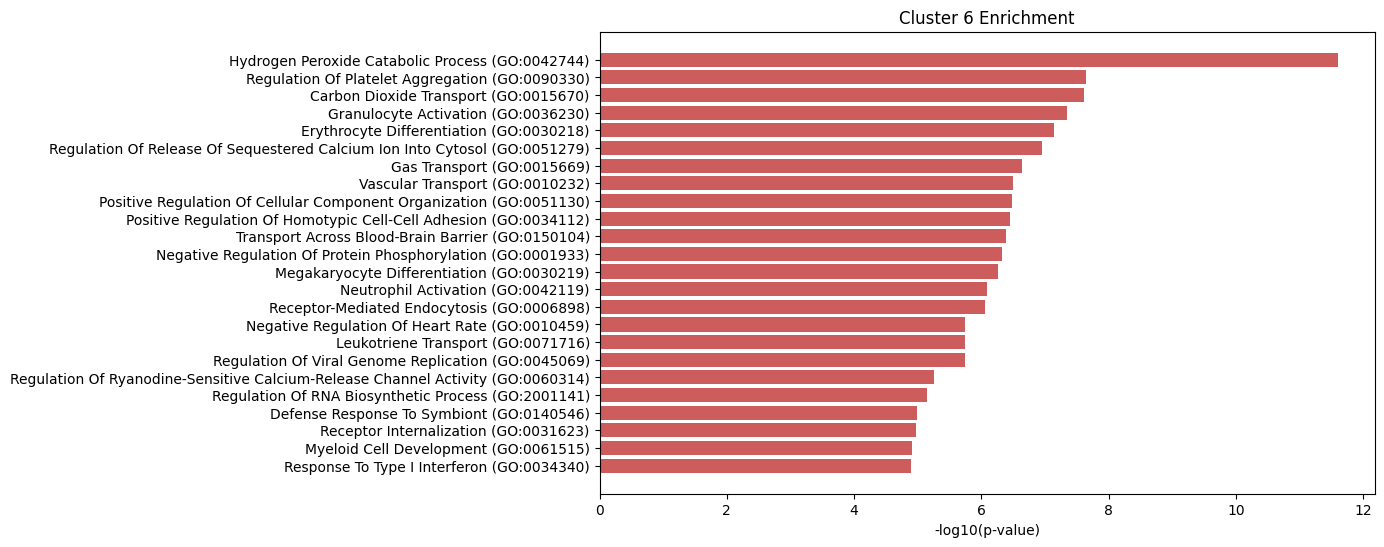

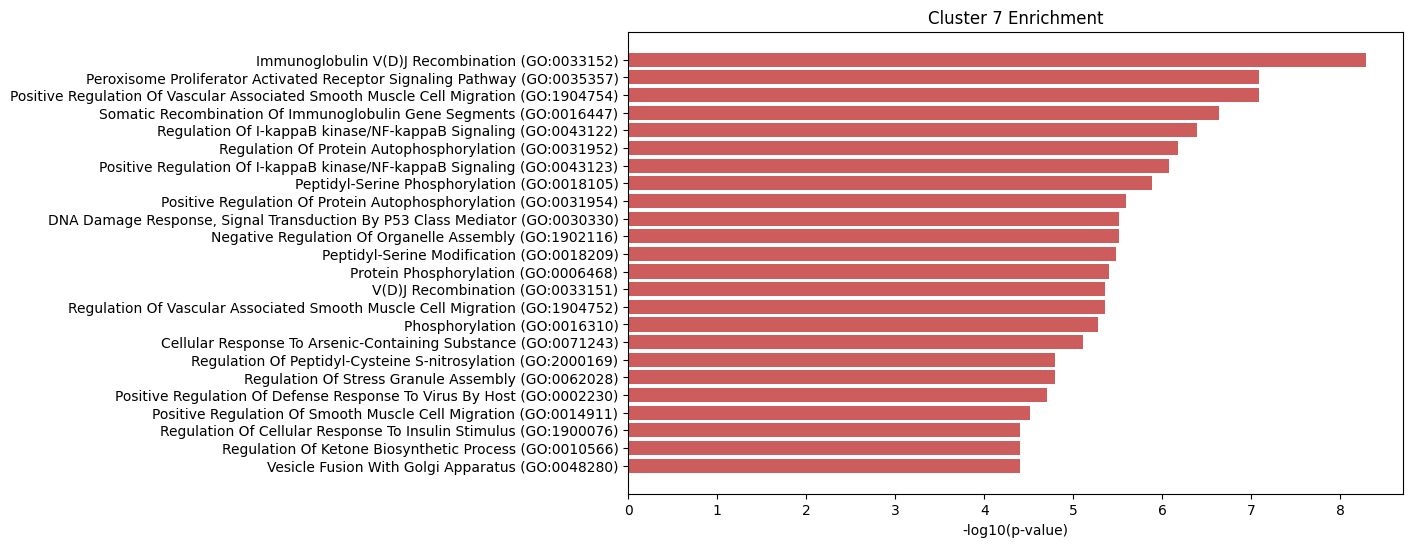

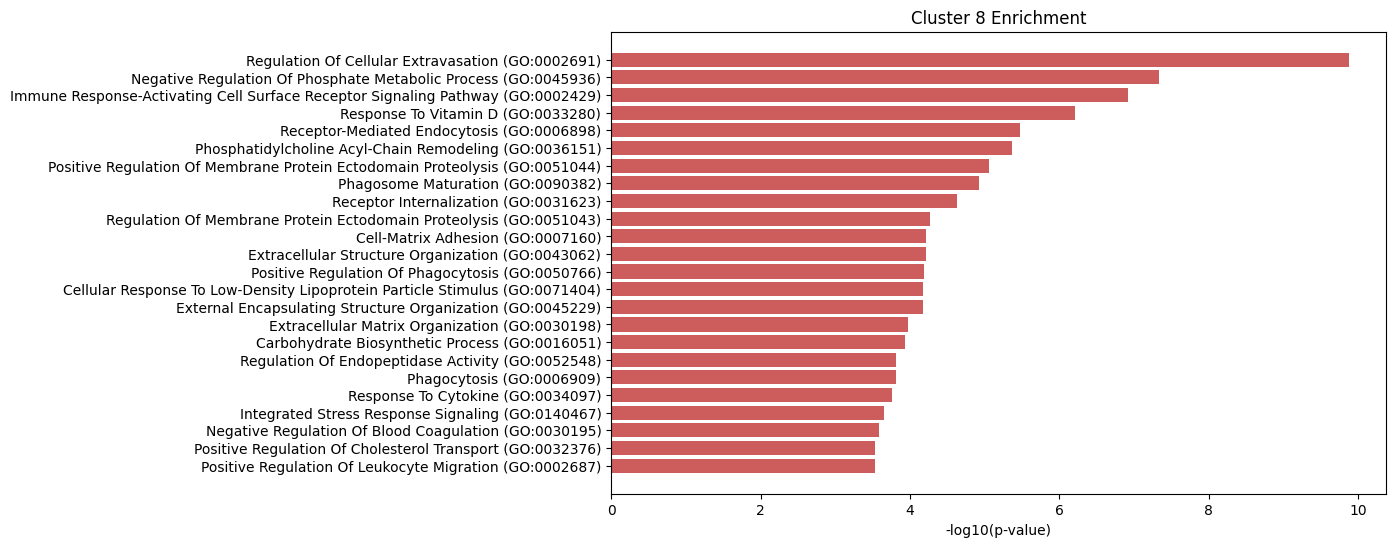

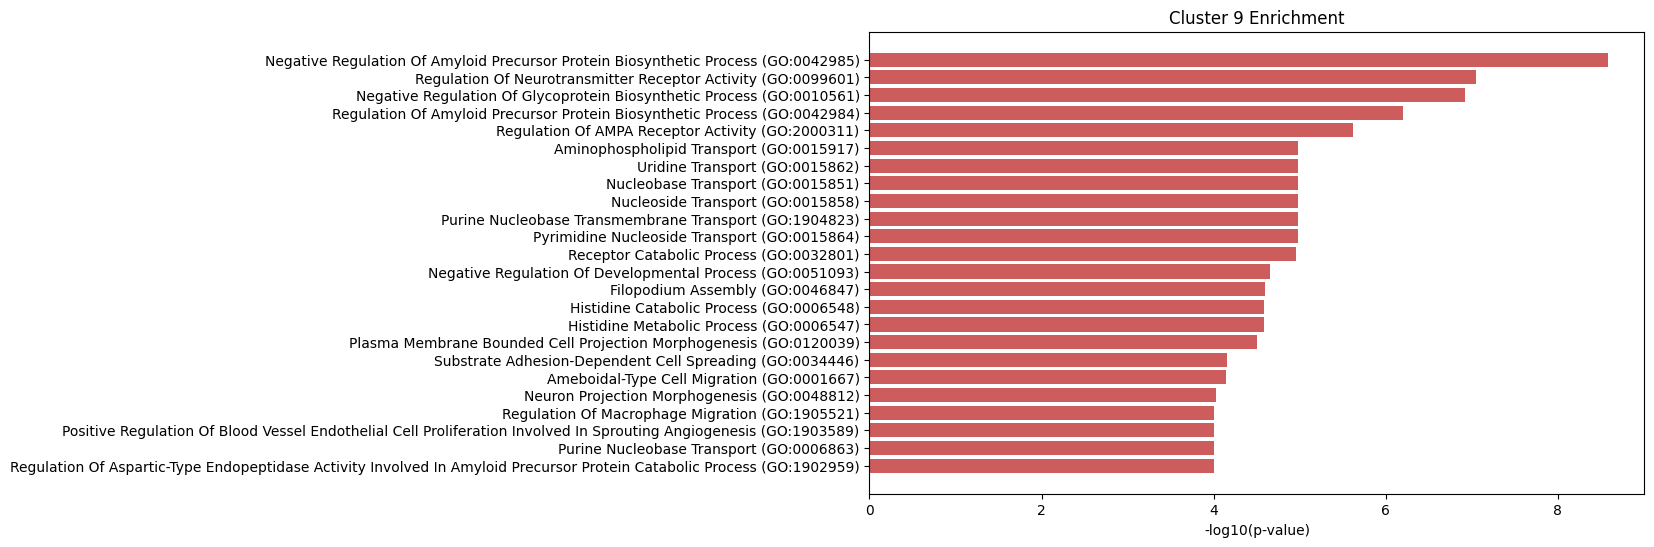

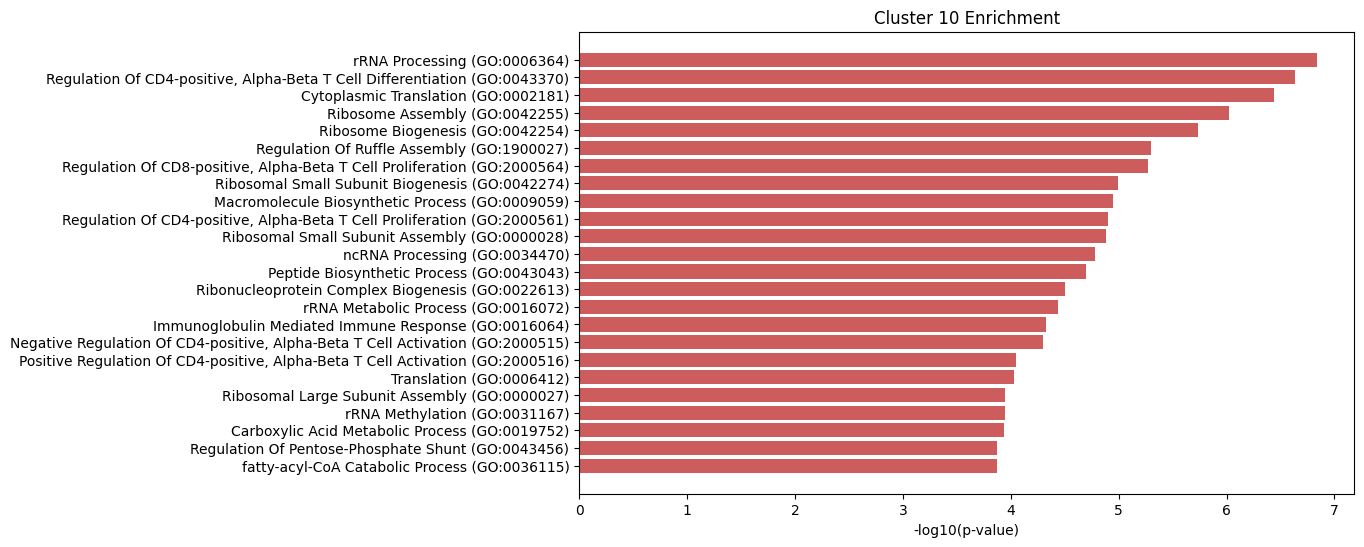

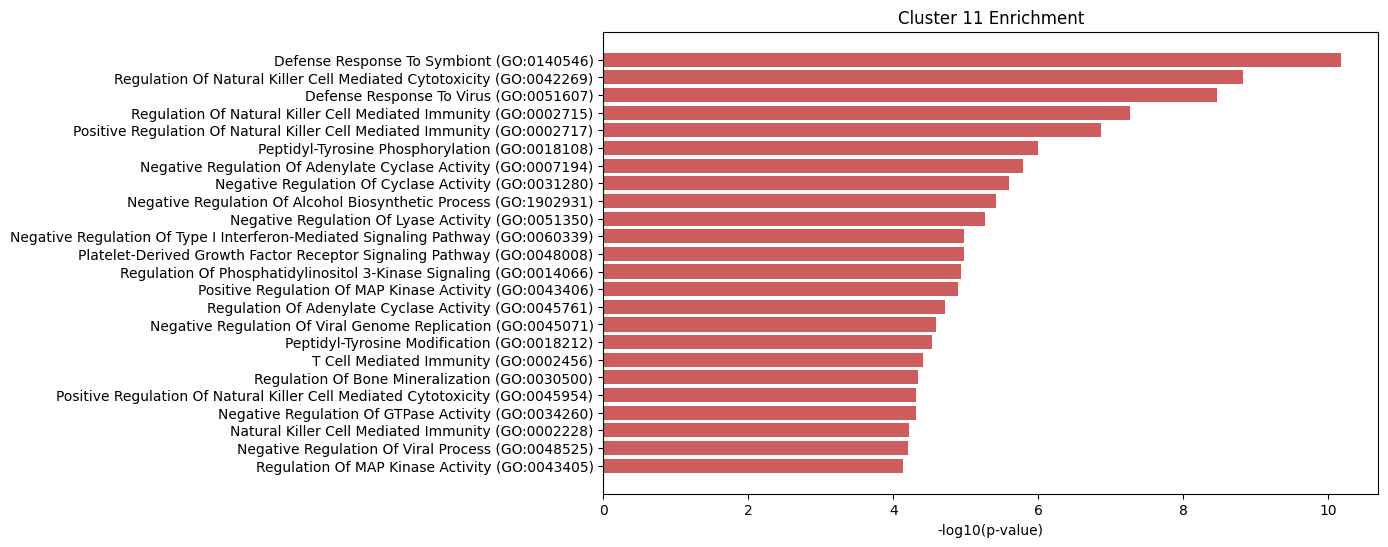

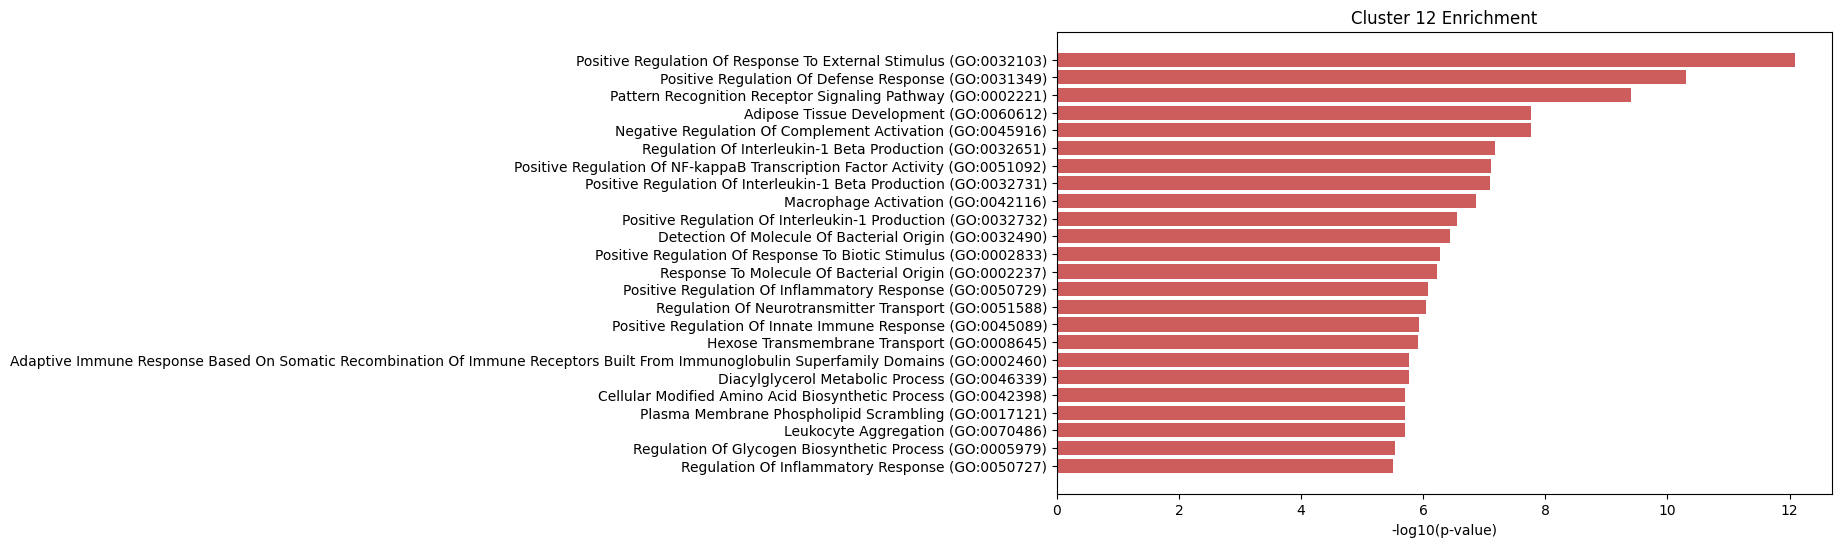

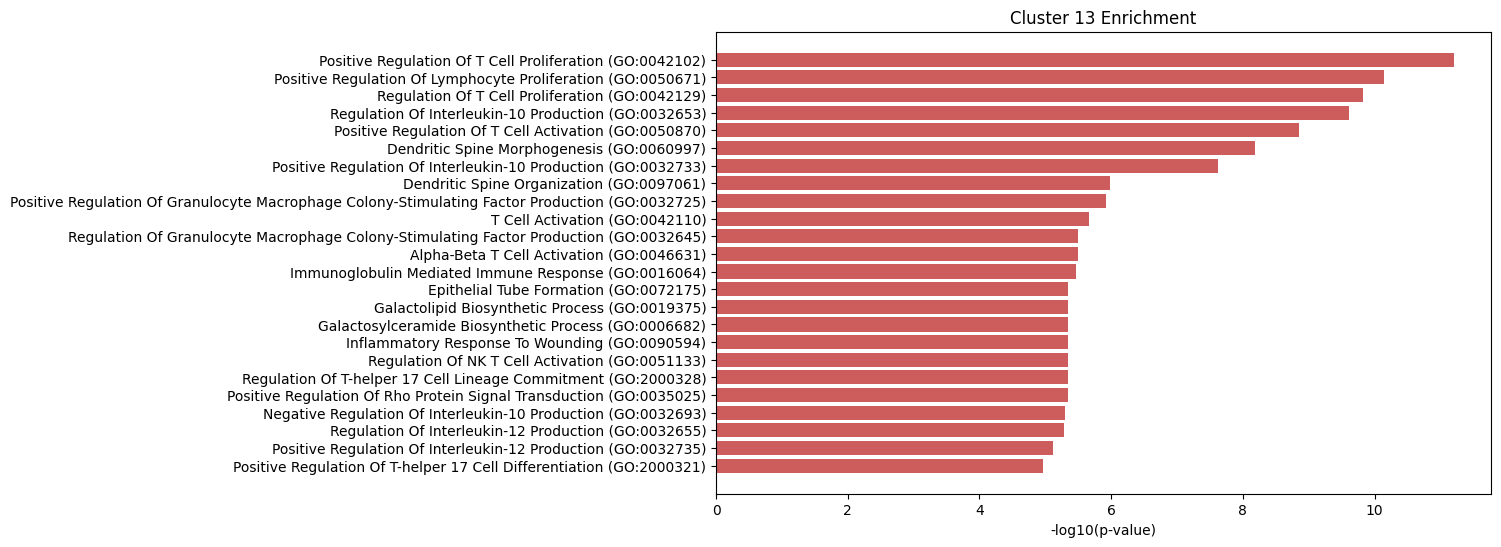

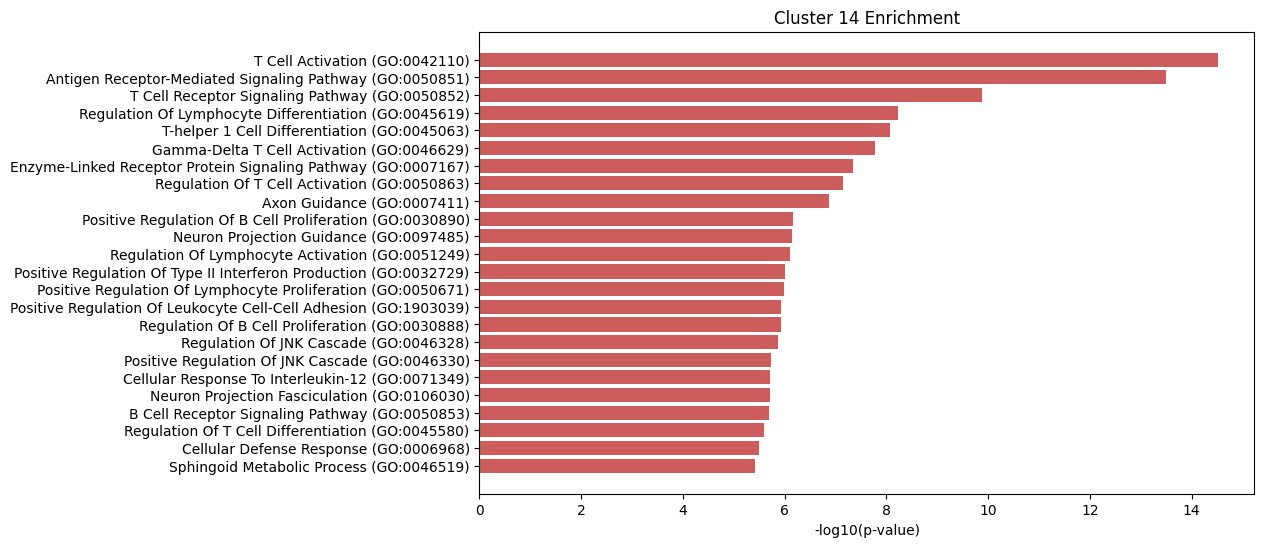

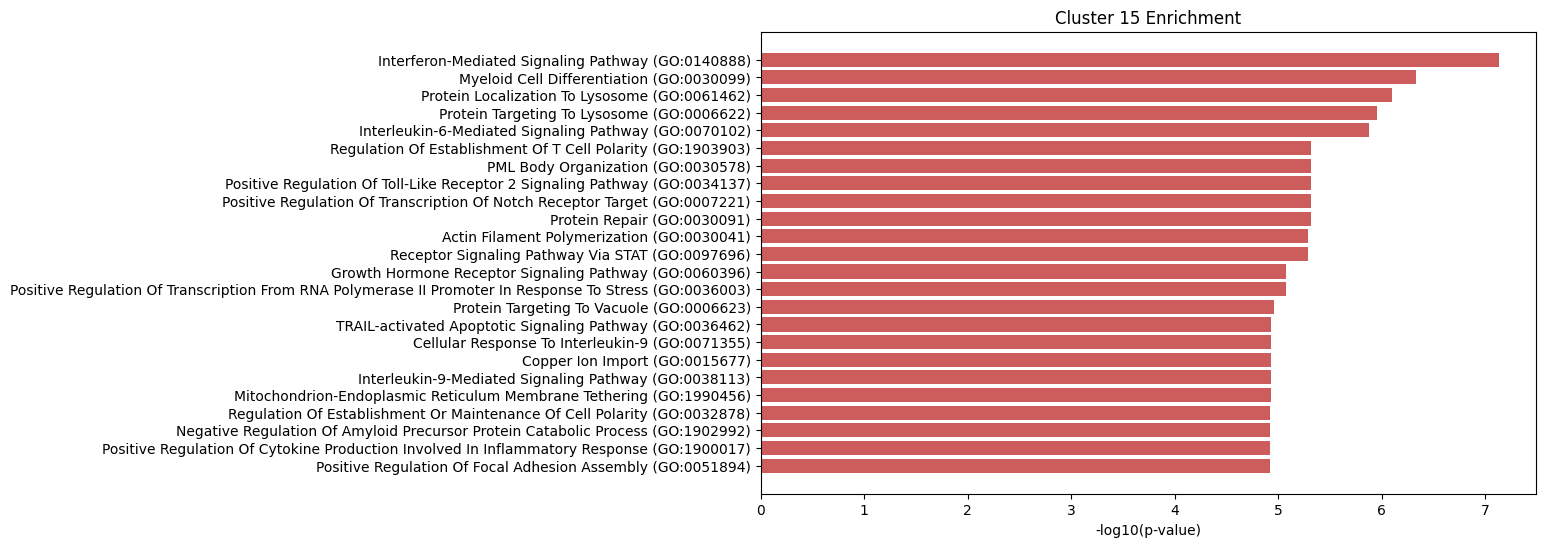

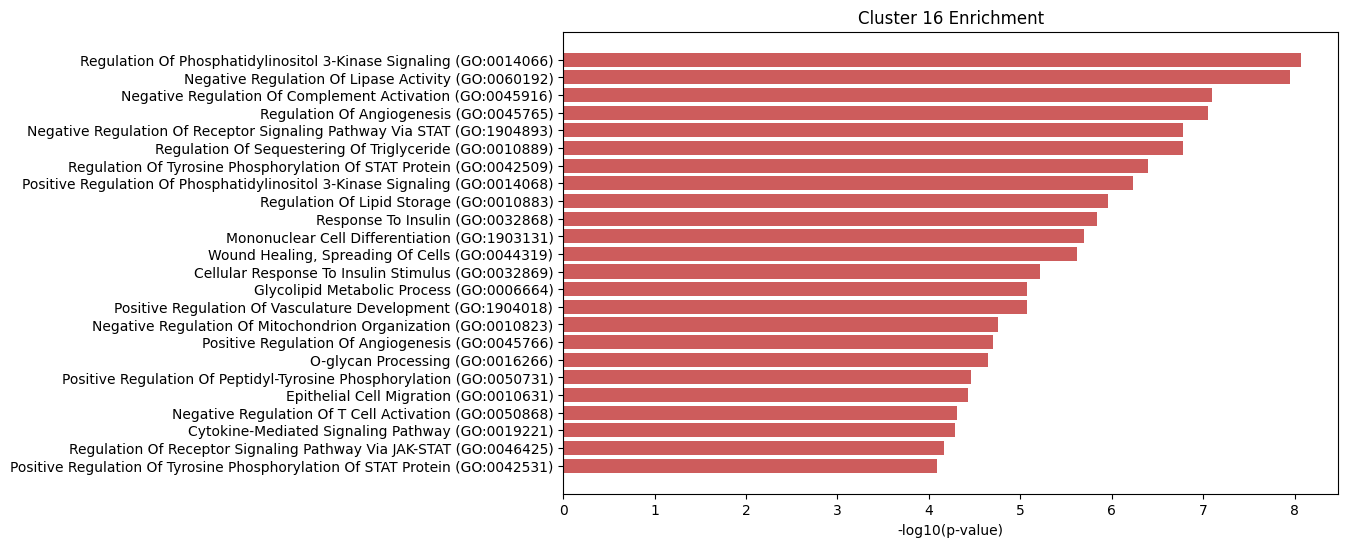

In [11]:

EnrichR.plot_enrichment_jpeg(gene_lists, library_name='GO_Biological_Process_2023', max_hits=24)
